### Author: William C Francis (willcf)
##Solution 2
### (i)

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision.utils import save_image
import cv2
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


####Downloading the dataset

In [3]:
trainset = torchvision.datasets.MNIST(root='./data', train = True, download = True, transform = transforms.ToTensor())
testset = torchvision.datasets.MNIST(root='./data', train = False, download = True, transform = transforms.ToTensor())
xtrain = trainset.data.numpy()
ytrain = trainset.targets.numpy()
x_val_pre = testset.data[:1000].numpy()
y_val = testset.targets[:1000].numpy()

### Creating x_train and y_train with 1000 images from each class and binarizing the pixels

In [4]:
count = np.zeros(10)
idx = []
for i in range(0, len(ytrain)):
  for j in range(10):
    if(ytrain[i] == j):
      count[j] += 1
      if(count[j]<=1000):
        idx = np.append(idx, i)
        
y_train = ytrain[idx.astype('int')]
x_train_pre = xtrain[idx.astype('int')]

### Resizing the images from 28x28 to 14x14

In [5]:
r,_,_ = x_train_pre.shape
x_train = np.zeros([r,14,14])
for i in range(r):
  a = cv2.resize(x_train_pre[i].astype('float32'), (14,14)) # Resizing the image from 28*28 to 14*14
  x_train[i] = a

r,_,_ = x_val_pre.shape
x_val = np.zeros([r,14,14])
for i in range(r):
  a = cv2.resize(x_val_pre[i].astype('float32'), (14,14)) # Resizing the image from 28*28 to 14*14
  x_val[i] = a

### Binarizing 

In [6]:
x_train = np.where(x_train > 128, 1, 0)
x_val = np.where(x_val > 128, 1, 0)
x_train = x_train.astype(np.float32)
x_val = x_val.astype(np.float32)

### Creating dataloaders

In [7]:
batch_size = 32
trainloader = torch.utils.data.DataLoader([[x_train[i], y_train[i]] for i in range(len(y_train))], shuffle=True, batch_size=batch_size)
testloader = torch.utils.data.DataLoader([[x_val[i], y_val[i]] for i in range(len(y_val))], shuffle=True, batch_size=100)

###(ii)
### Variational Auto Encoder model

In [9]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(196, 128) #Encoder
        self.fc21 = nn.Linear(128, 8) #mu
        self.fc22 = nn.Linear(128, 8) #sigma

        self.fc3 = nn.Linear(8, 128) #Decoder
        self.fc4 = nn.Linear(128, 196)
        
    def encoder(self, x):
        h = torch.tanh(self.fc1(x))
        return self.fc21(h), self.fc22(h) # mu, std
    
    def sampling(self, mu, std): # Reparameterization trick
        eps1 = torch.randn_like(std)
        eps2 = torch.randn_like(std)
        return 0.5*((eps1 * std + mu) + (eps2 * std + mu)) # Using two samples to compute expectation over z

    def decoder(self, z):
        h = torch.tanh(self.fc3(z))
        return torch.sigmoid(self.fc4(h)) 
    
    def forward(self, x):
        mu, std = self.encoder(x.view(-1, 196))
        z = self.sampling(mu, std)
        return self.decoder(z), mu, std
model = VAE()
if torch.cuda.is_available():
    model.cuda()

### Defining loss, optimizer and LR scheduler

In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.002)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', factor=0.5, 
                             patience=5, threshold=0.001, cooldown=0,
                             min_lr=0.0001, 
                             #verbose=True
                             )

def loss_function(y, x, mu, std): 
    ERR = F.binary_cross_entropy(y, x.view(-1, 196), reduction='sum')
    KLD = -0.5 * torch.sum(1 + torch.log(std**2) - mu**2 - std**2)
    return ERR + KLD, -ERR, -KLD

### Training and Validating

In [14]:
count=0
err_l, kld_l, n_wu, testl, update = [], [], [], [], []
for epoch in range(1, 20):
    
    train_loss = 0
    for batch_idx, (data, _) in enumerate(trainloader):
        model.train()
        #data = data.cuda()
        bsize = data.shape[0]
        recon_batch, mu, std = model(data)
        loss, err, kld = loss_function(recon_batch, data, mu, std)
        loss.backward()
        train_loss += err.item() + kld.item()
        optimizer.step()
        optimizer.zero_grad()
        err_l.append(err.item()/bsize)
        kld_l.append(kld.item()/bsize)
        count+=1
        n_wu.append(count)

        if (count%100 == 0): # Validating every 100 weight updates
          model.eval()
          a, _ = next(iter(testloader))
          #a = a.cuda()
          trecon, tmu, tstd = model(a)
          tloss, terr, tkld = loss_function(trecon, a, tmu, tstd)
          testl.append(terr/100)
          update.append(count)

    scheduler.step(train_loss / len(trainloader.dataset))
    
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(trainloader.dataset)))
    model.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in testloader:
            #data = data.cuda()
            recon, mu, std = model(data)
            loss, err, kld = loss_function(recon, data, mu, std)
            test_loss += err + kld
    
    test_loss /= len(testloader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

====> Epoch: 1 Average loss: -40.2852
====> Test set loss: -38.1531
====> Epoch: 2 Average loss: -37.5251
====> Test set loss: -36.8163
====> Epoch: 3 Average loss: -36.5035
====> Test set loss: -36.0605
====> Epoch: 4 Average loss: -35.8281
====> Test set loss: -35.5651
====> Epoch: 5 Average loss: -35.3060
====> Test set loss: -35.1240
====> Epoch: 6 Average loss: -34.8713
====> Test set loss: -34.7254
====> Epoch: 7 Average loss: -34.4298
====> Test set loss: -34.3504
====> Epoch: 8 Average loss: -34.2021
====> Test set loss: -34.3194
====> Epoch: 9 Average loss: -33.8418
====> Test set loss: -33.9357
====> Epoch: 10 Average loss: -33.5637
====> Test set loss: -34.0912
====> Epoch: 11 Average loss: -33.3965
====> Test set loss: -33.5663
====> Epoch: 12 Average loss: -33.2480
====> Test set loss: -33.6541
====> Epoch: 13 Average loss: -33.0674
====> Test set loss: -33.6244
====> Epoch: 14 Average loss: -32.8794
====> Test set loss: -33.3842
====> Epoch: 15 Average loss: -32.7545
====

### (iii) Plotting the first and second term of ELBO as a function of weight updates

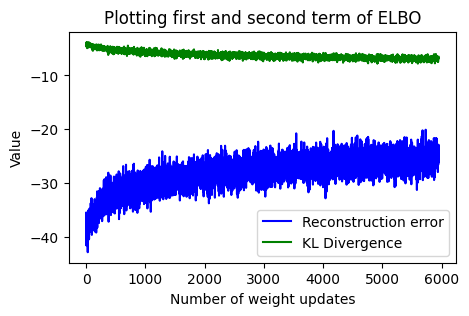

In [15]:
plt.figure(figsize=(5,3), dpi=100)
plt.plot(n_wu, err_l, 'b', label='Reconstruction error')
plt.plot(n_wu, kld_l, 'g', label='KL Divergence')
plt.title('Plotting first and second term of ELBO')
plt.xlabel('Number of weight updates')
plt.ylabel('Value')
plt.legend()
    

### (iv) 
### Visualizing input and output from the VAE from training set

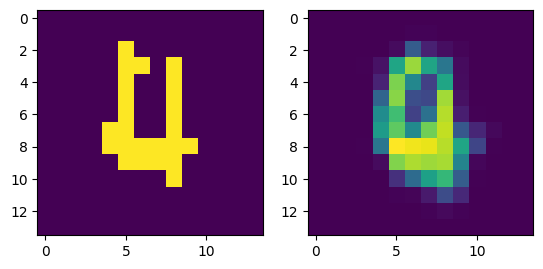

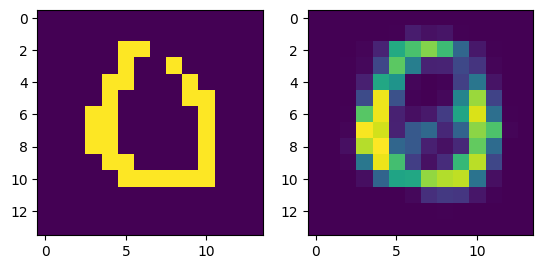

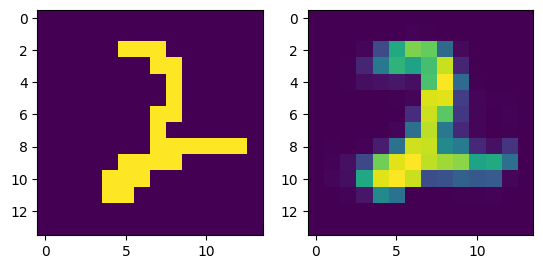

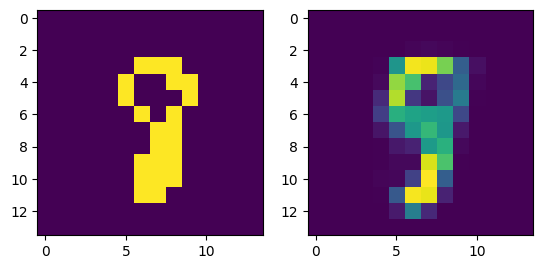

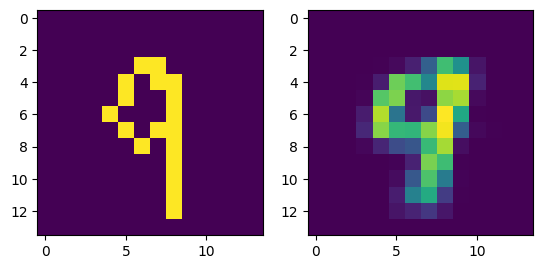

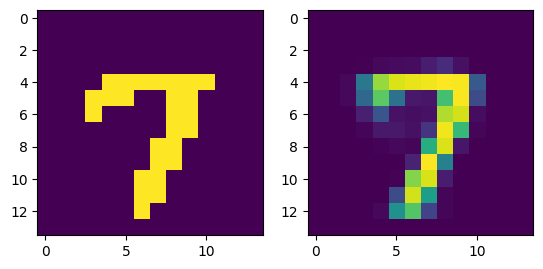

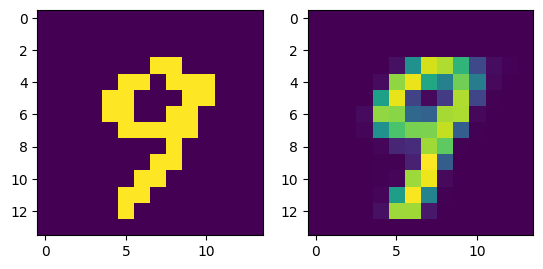

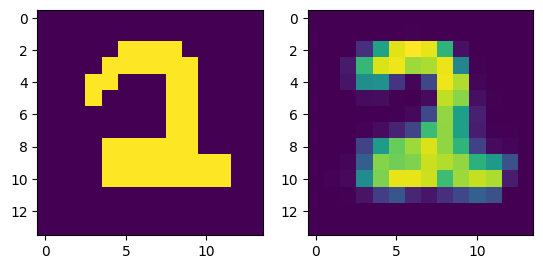

In [17]:
model.eval()
for i in range(8):
  a,t = next(iter(trainloader))
  #a = a.cuda()
  recon, mu, std = model(a[0])
  b = recon[0].reshape((14,14))
  f, axarr = plt.subplots(1,2)
  axarr[0].imshow(a[0].detach().cpu().numpy())
  axarr[1].imshow(b.detach().cpu().numpy())

### Visualizing input and output of the VAE from validation set

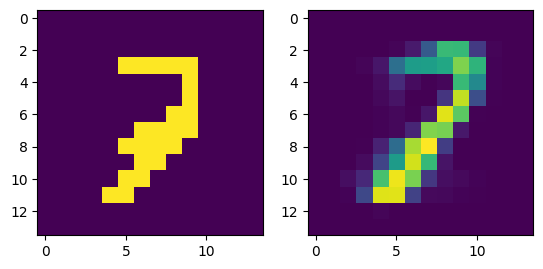

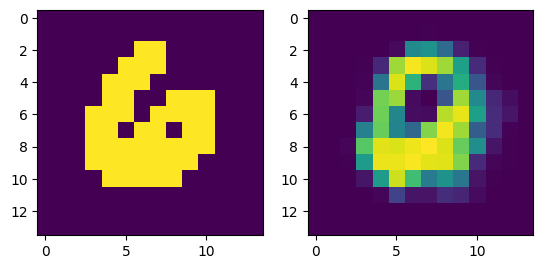

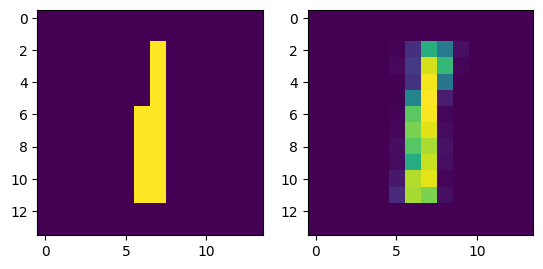

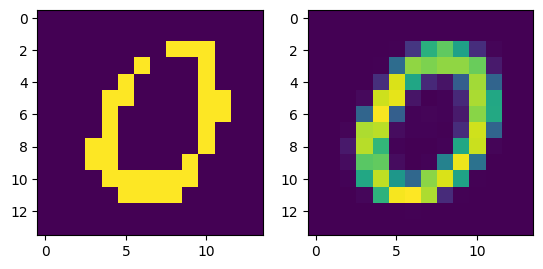

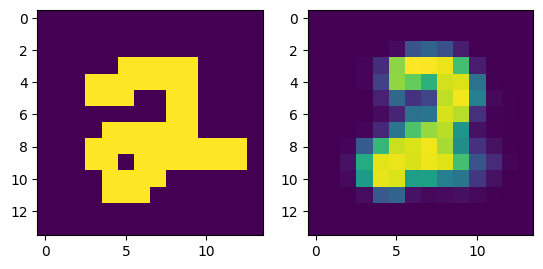

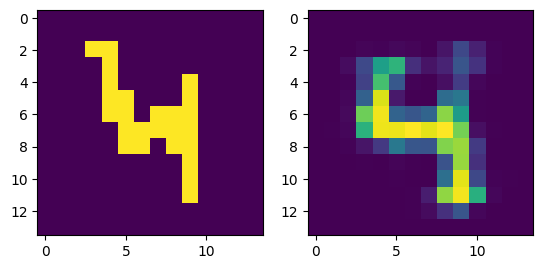

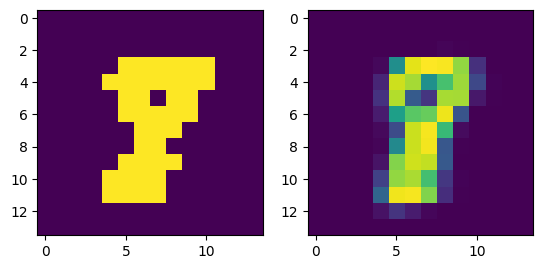

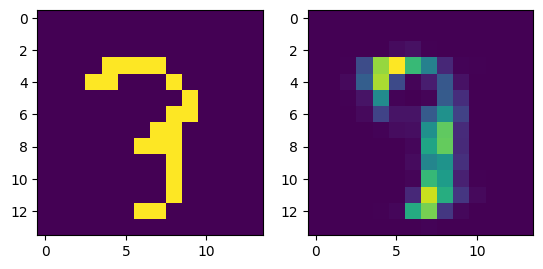

In [19]:
model.eval()
for i in range(8):
  a,t = next(iter(testloader))
  #a = a.cuda()
  recon, mu, std = model(a[0])
  b = recon[0].reshape((14,14))
  f, axarr = plt.subplots(1,2)
  axarr[0].imshow(a[0].detach().cpu().numpy())
  axarr[1].imshow(b.detach().cpu().numpy())

### (v)
### Synthesizing MNIST images from a Standard Gaussian Distribution

tensor([-1.1072,  0.1998,  0.9996, -1.7309, -1.4884, -2.3941,  0.9143,  0.8212])
tensor([ 8.8330e-01, -1.3302e-01, -7.9894e-01,  2.4306e-03,  3.3090e-01,
        -2.7454e+00,  2.6477e-01, -1.4895e+00])
tensor([-0.5977,  0.2496, -0.5668, -0.6594, -0.6436, -0.2741, -0.5172,  1.3764])
tensor([-0.5586, -0.6189,  0.4283,  1.4600, -0.0483,  1.8614, -0.3255, -0.1472])
tensor([-1.0640, -0.8890, -0.1934,  0.4671, -1.5749, -0.1468, -1.5800,  0.6195])
tensor([ 0.3863, -0.1939,  0.2222, -0.0501, -0.2358, -0.4284,  0.2071,  0.2881])
tensor([ 0.8961, -0.0185, -0.9970,  0.9681, -0.1085,  0.5911, -0.5218,  0.0160])
tensor([ 1.0731,  0.6104, -0.4193,  1.8280,  0.1760, -2.8549, -0.3267,  0.8645])


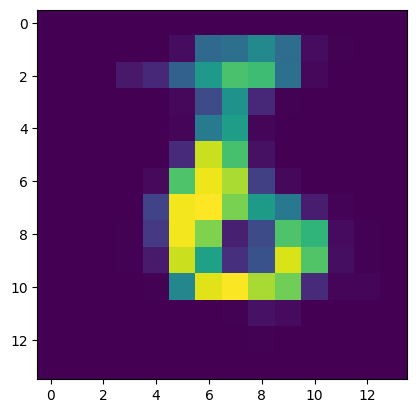

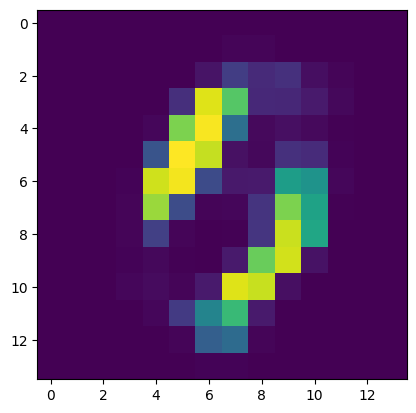

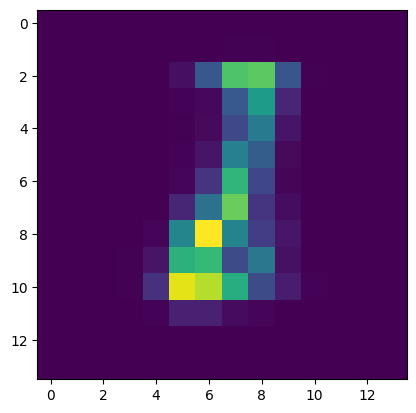

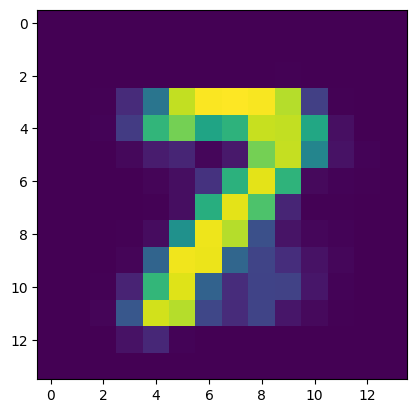

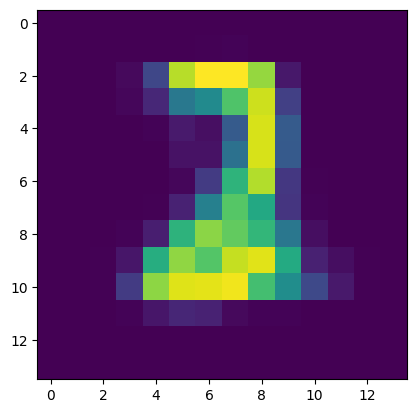

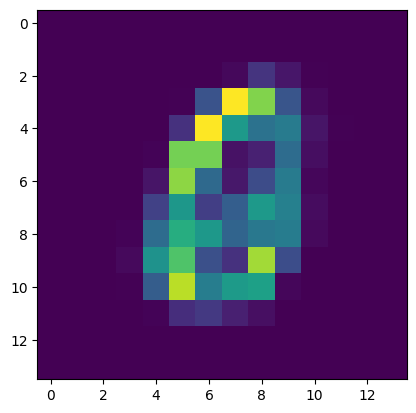

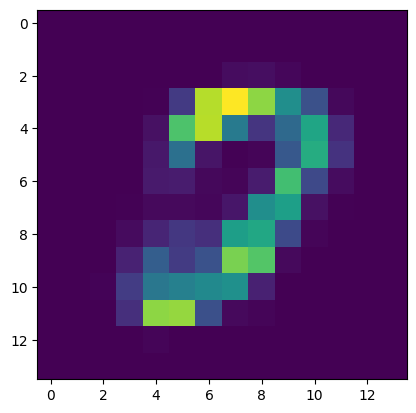

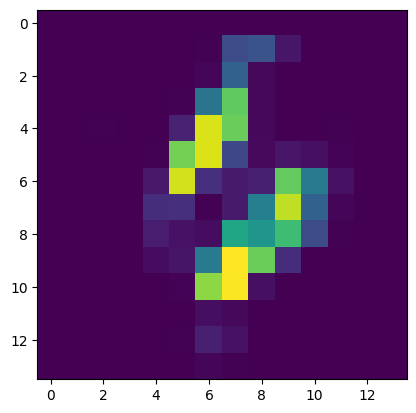

In [20]:

for i in range(8):
  
  x = np.random.normal(0,1, 8)
  x= x.astype(np.float32)
  x=torch.from_numpy(x)
  #x= x.cuda()
  recon = model.decoder(x)
  b = recon.reshape((14,14))
  print(x)
  f, axarr = plt.subplots(1) 
  axarr.imshow(b.detach().cpu().numpy())

### (vi)
### Comparing the reconstruction log likelihood term in ELBO on Training vs Validation set

C:\Users\kperc\AppData\Local\Temp\ipykernel_54248\1637448845.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testl = [torch.tensor(tensor).detach().numpy() for tensor in testl]


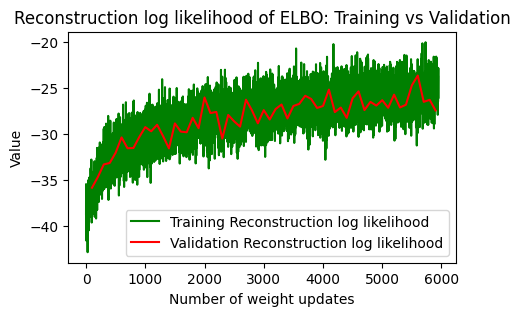

In [31]:
plt.figure(figsize=(5,3), dpi=100)
plt.plot(err_l, 'g', label='Training Reconstruction log likelihood')

#My addition
testl = [torch.tensor(tensor).detach().numpy() for tensor in testl]

plt.plot(update, testl, 'r', label='Validation Reconstruction log likelihood')
plt.title('Reconstruction log likelihood of ELBO: Training vs Validation')
plt.xlabel('Number of weight updates')
plt.ylabel('Value')
plt.legend()